# Pkg

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gaussian
from tqdm.notebook import tqdm as tqdm
import glob
import skimage.io

import cv2
import celluloid as cell
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import math

# Generating data

## tested params

In [ ]:
## THIS IS THE CURRENT SET OF PARAMS TESTED ##

# [[x = range(3)]]
# [[y = int((x+4)/3 * 2)]]

# [[z = range(3)]]
# [[zz = (z+4)/3 * 0.77]]

# set hand kinesin
# {
#     binding_rate = 10 % #/sec
#     binding_range = 0.1 % max distance from which can bind
#     bind_also_end = 1

#     unbinding_rate = [[zz]]
#     unbinding_force = 3

#     activity = move
#     unloaded_speed = [[y]] % 800 nm/s, for K401 \approx 400-500 nm/s
#                          % more velocity than speed
#     stall_force = 6

#     display = (
#         size=8;
#         color=blue;
#         width=7;
#     )
# }


In [200]:
%%bash
python3 preconfig.py test_template.cym.tpl
ls *0*.cym

4 files generated: test_template0000.cym ... test_template0003.cym
test_template0000.cym
test_template0001.cym
test_template0002.cym
test_template0003.cym


In [201]:
%%bash
python3 go_sim.py test_template0*.cym

Completed run `test_template0000.cym` in run0000
Completed run `test_template0001.cym` in run0001
Completed run `test_template0002.cym` in run0002
Completed run `test_template0003.cym` in run0003


In [191]:
%%bash
python3 scan.py '../play movie period=100 size=256 label={}' run*
python3 make_page.py run*

Process is interrupted.


# Data pipeline

## txt files

In [208]:
base_string = '000'
folder_list = glob.glob('run' + base_string + '*/')

text_files = [f + 'report.txt' for f in folder_list]

In [210]:
df = pd.read_csv(text_files[0],
                 sep="\n",
                 header=None)
rows = len(df.index)

## helper fxns

In [211]:
def make_hists(bin_num, pos_x, pos_y, im_nums):

    fig, ax = plt.subplots(dpi = 300)
    # hists = np.zeros(range(np.shape(pos_x)[0]), )

    ind = 0
    temp_pos_x = pos_x[ind]
    temp_pos_y = pos_y[ind]
    hist, xbins, ybins, im = ax.hist2d(temp_pos_x, temp_pos_y, bins = bin_num)

    hists = np.zeros((im_nums, len(xbins)-1,len(ybins)-1))

    for i in tqdm(range(im_nums)):
        ind = i
        temp_pos_x = pos_x[ind]
        temp_pos_y = pos_y[ind]

        hist, xbins, ybins, im = ax.hist2d(temp_pos_x, temp_pos_y, bins = bin_num);
        ax.set_aspect('equal', 'box')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


    #     fig.savefig('./heatmaps/heatmap' + str(i) + '.tiff', bbox_inches = 'tight')
        hists[i,:,:] = hist
        plt.close(fig)
    
    return hists

In [215]:
def read_result(file_name):
    data = []
    time = []
    count = 0
    
    df = pd.read_csv(file_name,
                 sep="\n",
                 header=None)
    rows = len(df.index)
    
    with open(file_name) as fp:

        new_data = False
        temp_data = []

        for x in range(rows):
            count += 1
            line = fp.readline()[:-1]
            lst = line.split(" ")
            lst = [val for val in lst if val != '' and val != '%']

            if len(lst) == 10:
                temp_data.append(lst)

            if lst and lst[0] == 'time':
                time.append(lst[1])

            if lst and lst[0] == 'end':
                if temp_data[1:]:
                    data.append(temp_data[1:])
                else:
                    time = time[:-1]
                temp_data = []

    data = np.array(data, dtype = 'float')
    return data

In [213]:
def find_centers(im_nums, hists):
    centers_tc = []
    radii = []
    frame_num = []
    contours_plot = []

    area_thresh = 1
    past_center = None
    areas = []

    #for loop thru MT images
    for i in tqdm(range(im_nums)):
        #crop image for center identification

        im = hists[i,:,:]

        #gaussian blur
        dst = im
        thresh = np.percentile(dst, 83)

        binary = (dst>thresh).astype(np.uint8)

        #create a contour
        contours, hierarchy = cv2.findContours(binary, 1, 2)

        #iterate through contours (for most connected region)
        max_area = 0
        max_index = None

        for j, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                max_index = j

        if max_area >= area_thresh:
            cnt = contours[max_index]
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            centers_tc.append([x, y])
            radii.append(radius)
            frame_num.append(i)

            cnt = np.array(cnt)
            cnt = np.squeeze(cnt)
            contours_plot.append(cnt)

        else:
            print("**CENTER NOT FOUND**")
            cnt = contours[max_index]
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            centers_tc.append([x, y])
            radii.append(radius)

            cnt = np.array(cnt)
            cnt = np.squeeze(cnt)
            contours_plot.append(cnt)

        areas.append(max_area)

    centers_tc = np.array(centers_tc)
    radii = np.array(radii)
    frame_num = np.array(frame_num)
    areas = np.array(areas)
    
    return centers_tc, radii, frame_num, areas

## Runn

In [216]:
temp_data = read_result(text_files[0])
temp_pos_x = temp_data[:,:,3]
temp_pos_y = temp_data[:,:,4]

row_num = np.shape(temp_pos_x)[0]
temp_bin_numb = 40

temp_hists = make_hists(temp_bin_numb, temp_pos_x, temp_pos_y, row_num)
temp_centers, temp_radii, temp_frame_num, temp_areas = find_centers(row_num, temp_hists)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [217]:
temp1_data = read_result(text_files[1])
temp1_pos_x = temp1_data[:,:,3]
temp1_pos_y = temp1_data[:,:,4]

row_num = np.shape(pos_x)[0]
temp1_bin_numb = 40

temp1_hists = make_hists(temp1_bin_numb, temp1_pos_x, temp1_pos_y, row_num)
temp1_centers, temp1_radii, temp1_frame_num, temp1_areas = find_centers(row_num, temp1_hists)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [218]:
def data_stack(list_of_files):

    frames = []
    centers = []
    radii = []
    areas = []
    hists_final = []
    
    for i in range(len(list_of_files)):
        temp_data = read_result(list_of_files[i])
        temp_pos_x = temp_data[:,:,3]
        temp_pos_y = temp_data[:,:,4]

        temp_hists = make_hists(temp_bin_numb, temp_pos_x, temp_pos_y, row_num)
        temp_centers, temp_radii, temp_frame_num, temp_areas = find_centers(row_num, temp_hists)
        
        centers.append(temp_centers)
        radii.append(temp_radii)
        frames.append(temp_frame_num)
        areas.append(temp_areas)
        hists_final.append(temp_hists)

    final_centers = np.stack(centers)
    final_radii = np.stack(radii)
    final_frames = np.stack(frames)
    final_areas = np.stack(areas)
    final_hists = np.stack(hists_final)
    
    return final_centers, final_radii, final_frames, final_areas, final_hists
        

In [219]:
text_files = np.sort(text_files)
c, r, f, a, h = data_stack(text_files)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

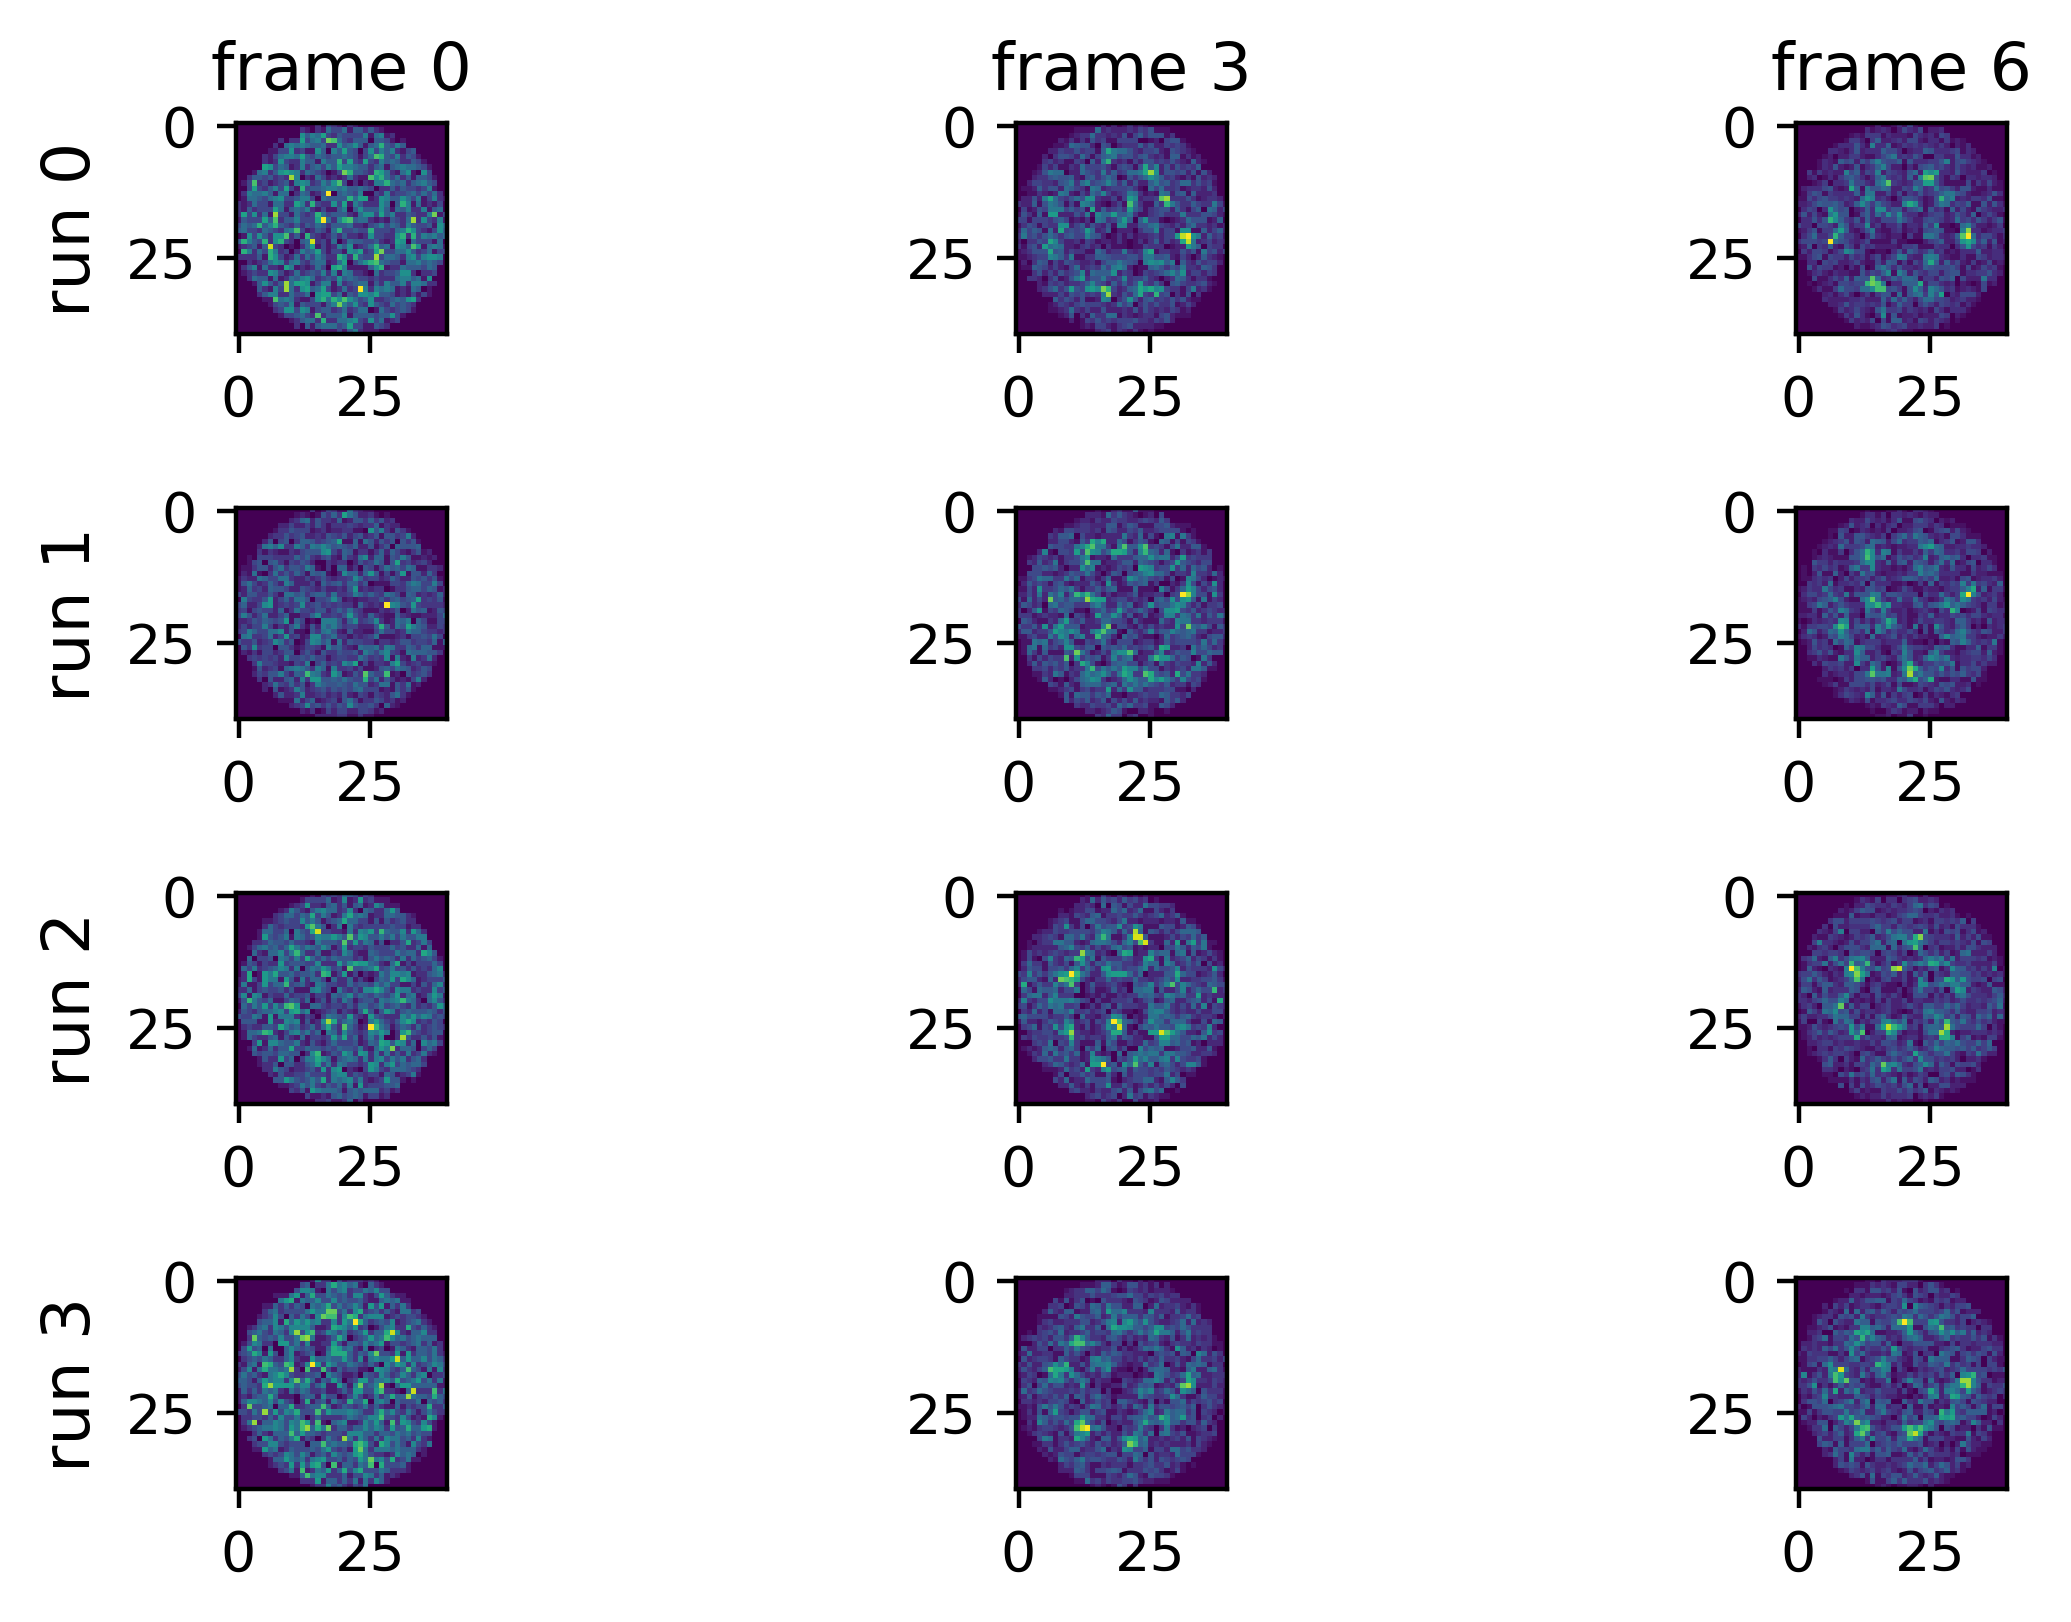

In [220]:
num_files = len(text_files)
num_steps = 3

param = a

fig, ax = plt.subplots(
    num_files,
    num_steps,
    dpi=400,
)
fig.tight_layout()

for i in range(num_files):
    for j in range(num_steps):
        ax_temp = ax[i, j]

        if (j == 0):
            ax_temp.set_ylabel('run ' + str(i), size='large')

        temp_frame_num = math.floor(row_num / num_steps * j)

        if (i == 0):
            ax_temp.set_title('frame ' + str(temp_frame_num), size='large')

        ax_temp.set_aspect('equal', 'box')
        ax_temp.imshow(h[i, temp_frame_num, :, :])

In [222]:
num_frames = np.shape(h)[1]

In [223]:
#plotting params

num_files = len(text_files)
num_steps = 3
height = 2
width = 2

labels_base_x = "unbinding rate "
labels_base_y = "motor speed " 

labels_vals_x = [0.38, 0.77]
labels_vals_y = [1, 2]

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

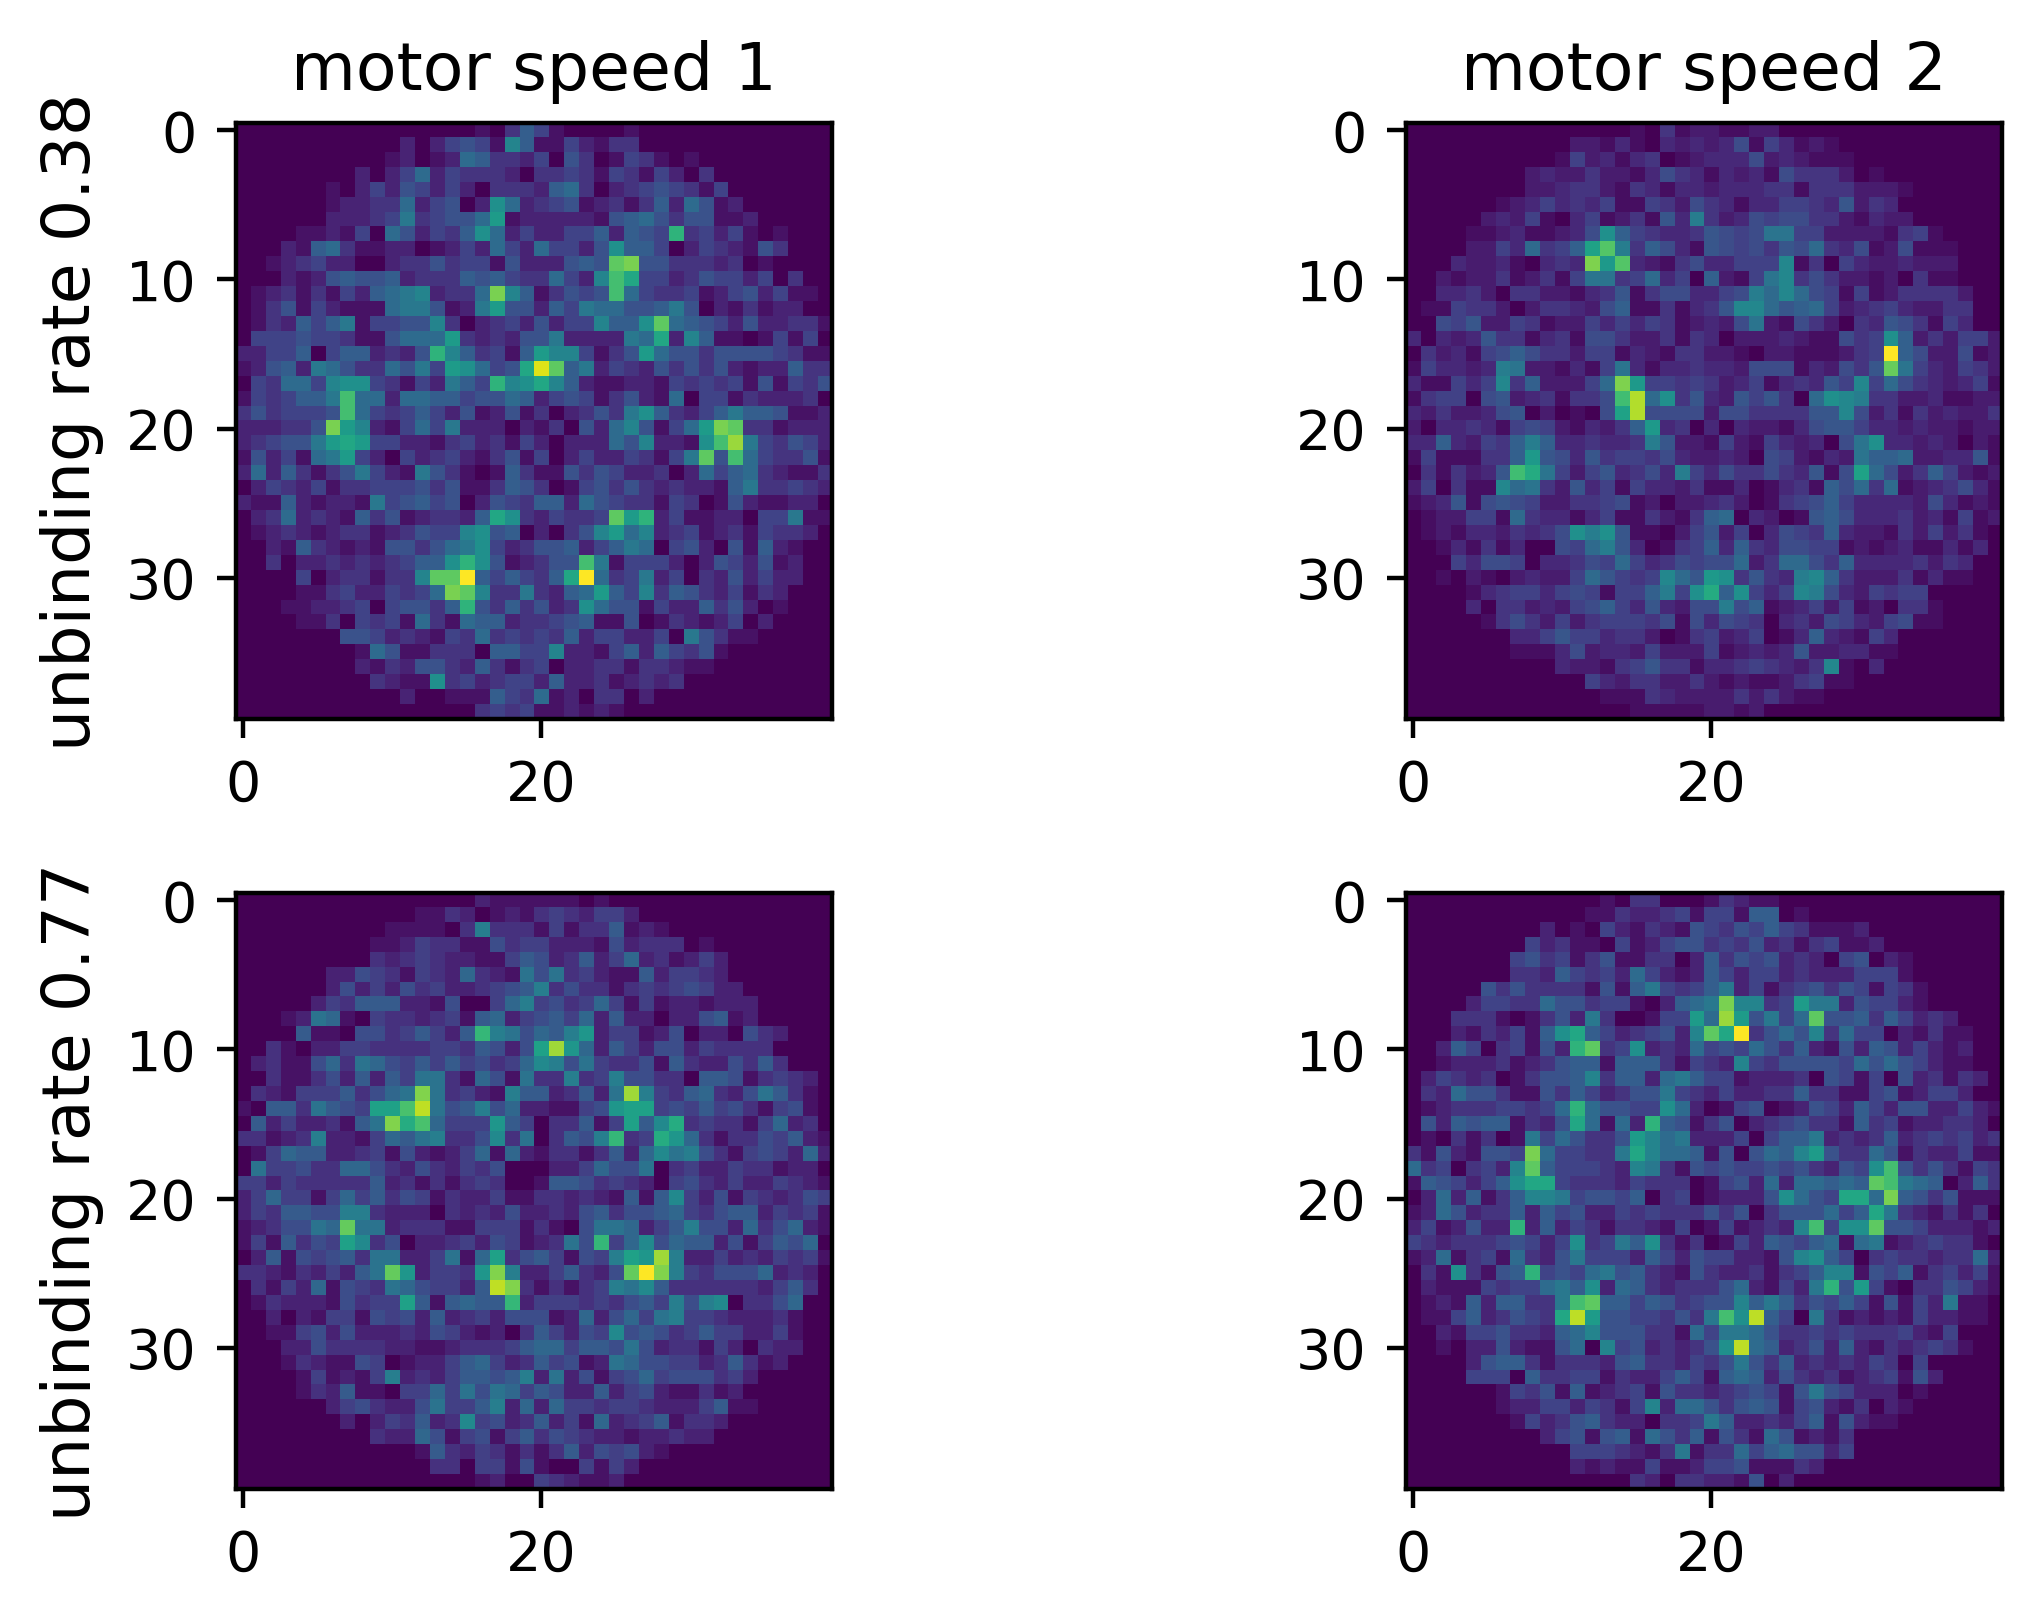

In [225]:
#animating

fig, ax = plt.subplots(
    height,
    width,
    dpi=400,
)
fig.tight_layout()
camera = cell.Camera(fig)

for j in tqdm(range(num_frames)):
    for i in range(num_files): 
        col = (i%height)
        row = math.floor((i - (i%width))/height)

        ax_temp = ax[row, col]

        if (row == 0):
            ax_temp.set_title(labels_base_y + str(labels_vals_y[col]), size='large')

        if (col == 0):
            ax_temp.set_ylabel(labels_base_x + str(labels_vals_x[row]), size='large')

        ax_temp.set_aspect('equal', 'box')
        ax_temp.imshow(h[i, j, :, :])
    
    camera.snap()

animation = camera.animate()
tqdm(animation.save("movie_2.mp4"))

# Parameters

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

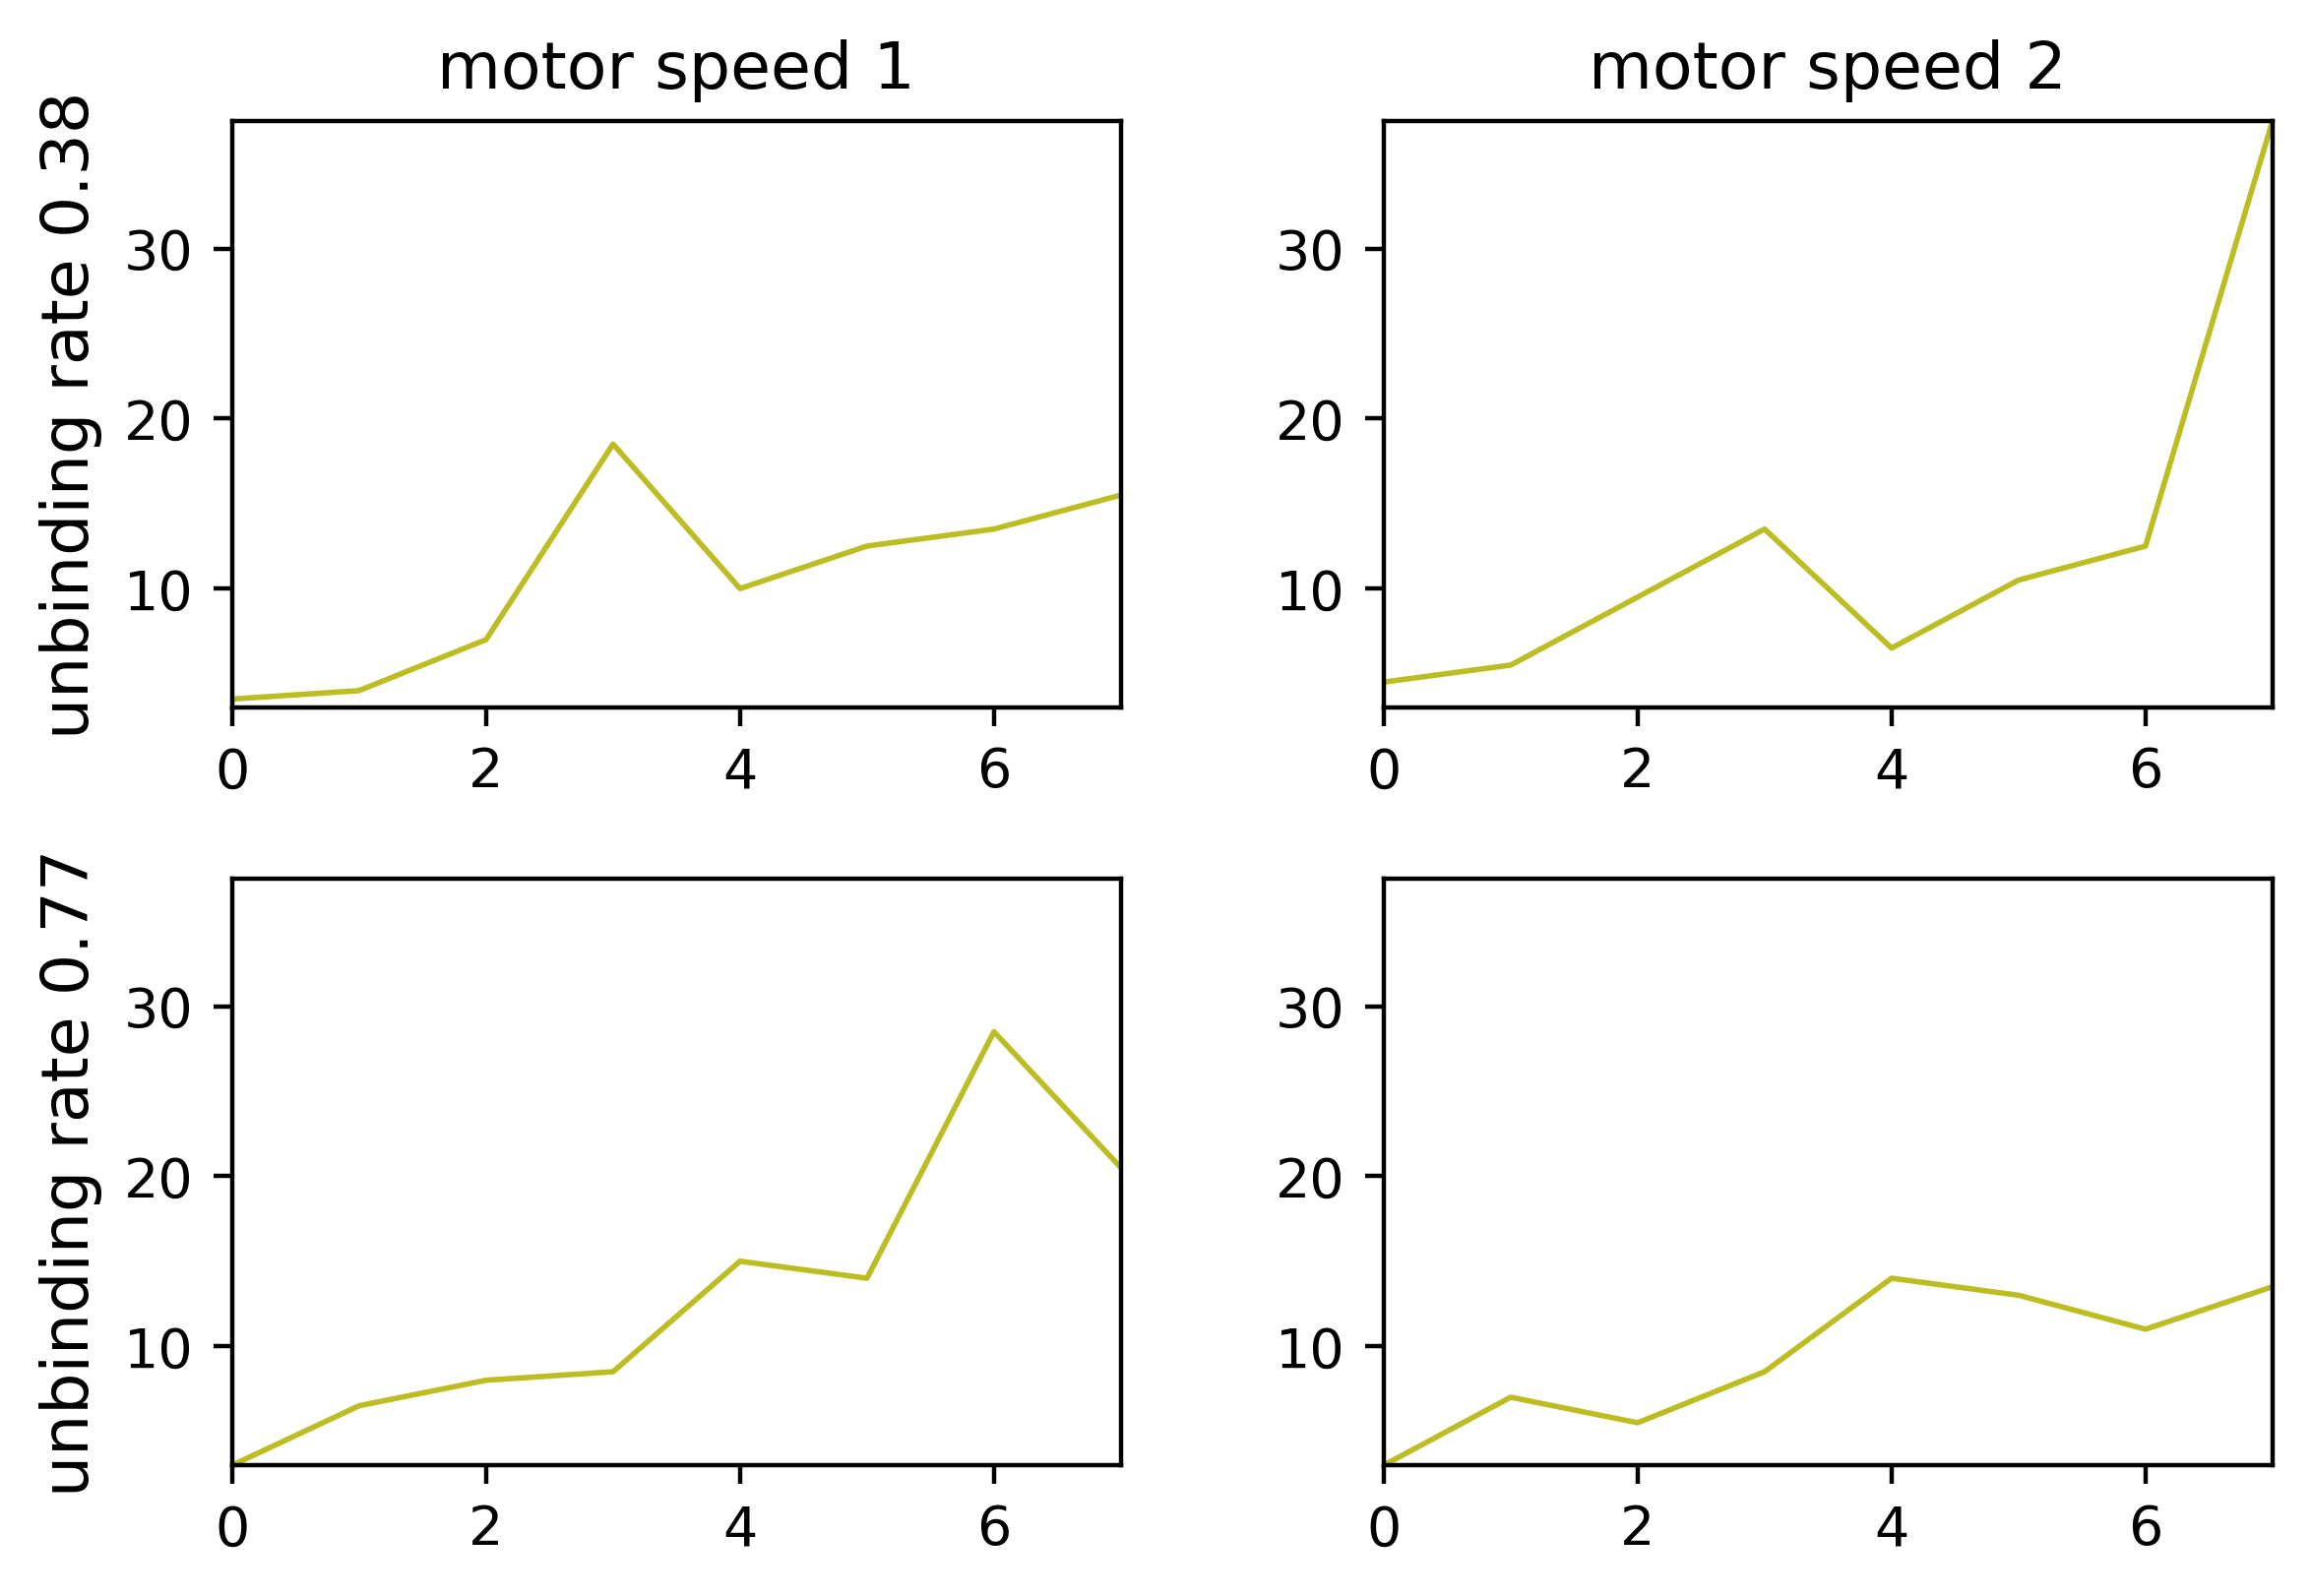

In [251]:
param_of_interest = a

#plotting params

num_files = len(text_files)
num_steps = 3
height = 2
width = 2

labels_base_x = "unbinding rate "
labels_base_y = "motor speed " 

labels_vals_x = [0.38, 0.77]
labels_vals_y = [1, 2]

xlim_min = 0
xlim_max = np.shape(param_of_interest[0])[0] - 2

ylim_min = np.min(param_of_interest)
ylim_max = np.max(param_of_interest)

#animating

fig, ax = plt.subplots(
    height,
    width,
    dpi=400,
)
fig.tight_layout()
camera = cell.Camera(fig)

for j in tqdm(range(num_frames)):
    for i in range(num_files): 
        col = (i%height)
        row = math.floor((i - (i%width))/height)

        param_array = None
        num_indices = 2
        
        if (num_indices == 2):
            param_array = param_of_interest[i,:j]
            
        ax_temp = ax[row, col]

        if (row == 0):
            ax_temp.set_title(labels_base_y + str(labels_vals_y[col]), size='large')

        if (col == 0):
            ax_temp.set_ylabel(labels_base_x + str(labels_vals_x[row]), size='large')

        ax_temp.set_xlim(xlim_min, xlim_max)
        ax_temp.set_ylim(ylim_min, ylim_max)
        ax_temp.plot(param_array, linewidth = 1)
    
    camera.snap()

animation = camera.animate()
tqdm(animation.save("movie_2.mp4"))

3.0

In [237]:
min(np.array([0,1,2]))

0

In [235]:
np.maximum(np.array([0,1,2]))

ValueError: invalid number of arguments

# Commands to remove files

In [226]:
%%bash
rm -r run0*/

In [227]:
%%bash
rm -r *template0*.cym